In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

In [2]:
warnings.simplefilter("ignore")

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.initializers import RandomUniform
import keras.backend as K

In [4]:
#Importing the dataset 
X_dev=pd.read_csv("X_dev.csv")
y_dev=pd.read_csv("y_dev.csv")

X_dev.drop(['Unnamed: 0'], axis=1, inplace =True)
y_dev.drop(['Unnamed: 0'], axis=1, inplace =True)

In [5]:
def MEE(y_real, y_pred, **kwarg):
    sum_t = 0
    for i in range(len(y_real)):
        sum_t += np.sqrt(np.power((y_real[i][0]-y_pred[i][0]), 2)+np.power((y_real[i][1]-y_pred[i][1]), 2))
    return sum_t / len(y_real)

MEE=make_scorer(MEE, greater_is_better=False)

In [6]:
def MEE_k(y_real, y_pred):
     return K.mean(K.sqrt(K.sum(K.square(y_pred - y_real), axis=-1)))

In [7]:
kf=KFold(n_splits=5, random_state=None, shuffle=True)

In [8]:
def create_model(lr=0.1, mom=0.1, alpha=0.01, unit1=10, unit2=10, act='sigmoid'):
    # create model
    model = Sequential()
    model.add(Dense(unit1, input_dim=10, activation=act, 
                    kernel_regularizer=l2(alpha), 
                    kernel_initializer=RandomUniform(minval=-0.7, maxval=0.7, seed=1)))
    model.add(Dense(unit2, activation=act, 
                    kernel_regularizer=l2(alpha),
                    kernel_initializer=RandomUniform(minval=-0.7, maxval=0.7, seed=1)))
    model.add(Dense(2, activation='linear'))
    # Compile model
    model.compile(loss=[MEE_k], optimizer= SGD(lr=lr, momentum=mom))
    return model

In [9]:
hyper_params_space = {
        'unit1' : [25, 30, 40, 50, 80],
        'lr' : [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
        'unit2': [5, 15, 25, 35],
        'mom' : [0.01, 0.1, 0.5, 0.7, 0.9],
        'alpha' : [0.1, 1e-5, 1e-8, 1e-10, 1e-20],
        'act' : ['sigmoid', 'softmax']
    },


print('===================================')
model = KerasRegressor(build_fn=create_model, batch_size=1036, epochs=600)
mlpr = GridSearchCV( model
                    , hyper_params_space, scoring='r2', cv=kf, 
                    refit='r2', 
                    n_jobs=2)
mlpr.fit(X_dev, y_dev)
print("DONE")
mlpr.best_estimator_.model.save("test_model2HL.h5")
resultGSCV=pd.DataFrame(mlpr.cv_results_)
#print(pd.DataFrame(mlpr.cv_results_))
resultGSCV.to_csv(r'try2HL.csv')



Epoch 1/600
2/2 [==============================] - 0s 20ms/step - loss: 57.0625
Epoch 2/600
2/2 [==============================] - 0s 3ms/step - loss: 52.6237
Epoch 3/600
2/2 [==============================] - 0s 15ms/step - loss: 45.0907
Epoch 4/600
2/2 [==============================] - 0s 18ms/step - loss: 34.6479
Epoch 5/600
2/2 [==============================] - 0s 17ms/step - loss: 24.0360
Epoch 6/600
2/2 [==============================] - 0s 3ms/step - loss: 18.8218
Epoch 7/600
2/2 [==============================] - 0s 2ms/step - loss: 16.9086
Epoch 8/600
2/2 [==============================] - 0s 3ms/step - loss: 16.1172
Epoch 9/600
2/2 [==============================] - 0s 3ms/step - loss: 15.1929
Epoch 10/600
2/2 [==============================] - 0s 7ms/step - loss: 13.8942
Epoch 11/600
2/2 [==============================] - 0s 14ms/step - loss: 11.7342
Epoch 12/600
2/2 [==============================] - 0s 13ms/step - loss: 9.7995
Epoch 13/600
2/2 [==========================

In [10]:
mlpr.best_params_

{'act': 'sigmoid',
 'alpha': 1e-08,
 'lr': 0.2,
 'mom': 0.5,
 'unit1': 80,
 'unit2': 25}

In [11]:
X_dev=X_dev.to_numpy()
y_dev=y_dev.to_numpy()

In [12]:
def create_modelLC():
    # create model
    model = Sequential()
    model.add(Dense(50, input_dim=10, activation=mlpr.best_params_['act'], 
                    kernel_regularizer=l2(mlpr.best_params_['alpha']),
                    kernel_initializer=RandomUniform(minval=-0.7, maxval=0.7, seed=1)))
    model.add(Dense(25, activation=mlpr.best_params_['act'], 
                    kernel_regularizer=l2(mlpr.best_params_['alpha']),
                    kernel_initializer=RandomUniform(minval=-0.7, maxval=0.7, seed=1)))
    model.add(Dense(2, activation='linear'))
    # Compile model
    model.compile(loss=[MEE_k], optimizer= SGD(lr=mlpr.best_params_['lr'], 
                                                            momentum=mlpr.best_params_['mom']))
    return model

In [13]:
historyVal = []
historyTr = []

mc = ModelCheckpoint('best_modelLC2HL.h5', monitor='val_loss', save_best_only=True)

for traing_index, test_index in kf.split(X_dev):
    x_tr = X_dev[traing_index]
    y_tr = y_dev[traing_index]
    x_val = X_dev[test_index]
    y_val = y_dev[test_index]
    model=create_modelLC()
    #model.add_loss(MEE_k)
    history=model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=600, 
                      batch_size=1036).history
    historyVal.append(history['val_loss'])
    historyTr.append(history['loss'])
model=create_modelLC()
#model.add_loss(MEE_k)
model.fit(X_dev, y_dev, epochs=600, 
                      batch_size=1036, callbacks=[mc]).history

Epoch 1/600
1/1 [==============================] - 0s 311ms/step - loss: 57.6771 - val_loss: 56.2214
Epoch 2/600
1/1 [==============================] - 0s 104ms/step - loss: 56.2941 - val_loss: 54.1453
Epoch 3/600
1/1 [==============================] - 0s 83ms/step - loss: 54.2270 - val_loss: 51.5861
Epoch 4/600
1/1 [==============================] - 0s 74ms/step - loss: 51.6781 - val_loss: 48.4797
Epoch 5/600
1/1 [==============================] - 0s 81ms/step - loss: 48.5812 - val_loss: 44.7068
Epoch 6/600
1/1 [==============================] - 0s 71ms/step - loss: 44.8175 - val_loss: 40.2267
Epoch 7/600
1/1 [==============================] - 0s 85ms/step - loss: 40.3509 - val_loss: 35.1406
Epoch 8/600
1/1 [==============================] - 0s 91ms/step - loss: 35.2926 - val_loss: 29.7562
Epoch 9/600
1/1 [==============================] - 0s 138ms/step - loss: 29.9579 - val_loss: 24.7929
Epoch 10/600
1/1 [==============================] - 0s 80ms/step - loss: 24.9970 - val_loss: 21.5

{'loss': [57.05015563964844,
  53.171043395996094,
  46.5507926940918,
  36.99473190307617,
  26.040374755859375,
  19.568592071533203,
  17.22986602783203,
  16.204267501831055,
  15.242791175842285,
  13.160062789916992,
  11.015542030334473,
  9.67701530456543,
  8.843560218811035,
  8.503936767578125,
  8.25266170501709,
  8.02049446105957,
  7.79696798324585,
  7.6155219078063965,
  7.440563201904297,
  7.283231735229492,
  7.063515663146973,
  6.849289417266846,
  6.667182445526123,
  6.452054977416992,
  6.238813400268555,
  6.037026405334473,
  5.831389427185059,
  5.63300085067749,
  5.434781551361084,
  5.246070861816406,
  5.110358715057373,
  4.897441864013672,
  4.748498439788818,
  4.5839056968688965,
  4.473978042602539,
  4.373469352722168,
  4.199521064758301,
  4.109156131744385,
  4.019137859344482,
  3.9532527923583984,
  3.8834526538848877,
  3.818004608154297,
  3.7838854789733887,
  3.730419635772705,
  3.661461591720581,
  3.632031202316284,
  3.590956687927246,

In [14]:
historyVal_mean=np.mean(historyVal, axis=0)
historyTr_mean=np.mean(historyTr, axis=0)

historyVal_sd=np.std(historyVal, axis=0)
historyTr_sd=np.std(historyTr, axis=0)

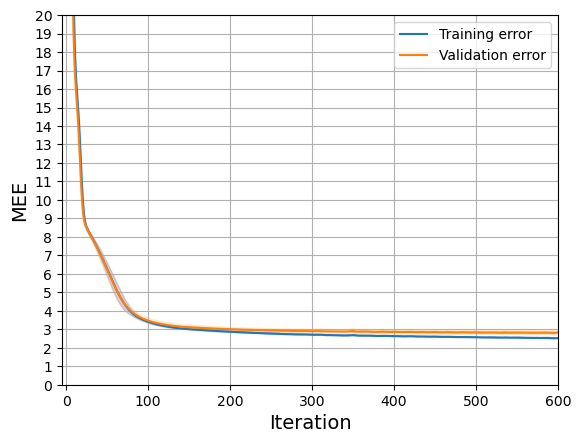

In [15]:
plt.style.use('default')

plt.plot(range(len(historyTr_mean)),historyTr_mean, label = 'Training error')
plt.fill_between(range(len(historyTr_mean)), historyTr_mean - historyTr_sd, historyTr_mean + historyTr_sd, 
                 color='b', alpha=0.15)

plt.plot(range(len(historyVal_mean)), historyVal_mean, label = 'Validation error')
plt.fill_between(range(len(historyVal_mean)), historyVal_mean - historyVal_sd, 
                 historyVal_mean + historyVal_sd, 
                 color='orange', alpha=0.15)

plt.ylabel('MEE', fontsize = 14)
plt.xlabel('Iteration', fontsize = 14)
plt.legend()
plt.ylim(5,20)
plt.xlim(-5,600)
plt.yticks(np.arange(0, 21, +1))

plt.grid()

In [16]:
print("Best model result:")
print("MEE on the validation",historyVal_mean[-1],"with standard deviation",historyVal_sd[-1])
print("MEE on the training",historyTr_mean[-1],"with standard deviation",historyTr_sd[-1])

Best model result:
MEE on the validation 2.8200313091278075 with standard deviation 0.1331580348681592
MEE on the training 2.520401620864868 with standard deviation 0.023011841736000863


In [17]:
def create_model_NoReg():
    # create model
    model = Sequential()
    model.add(Dense(mlpr.best_params_['unit1'], input_dim=10, activation=mlpr.best_params_['act'], 
                    ))
    model.add(Dense(mlpr.best_params_['unit2'], activation=mlpr.best_params_['act'], 
                    ))
    model.add(Dense(2, activation='linear'))
    # Compile model
    model.compile(loss=[MEE_k], optimizer= SGD(lr=mlpr.best_params_['lr'], 
                                                            momentum=mlpr.best_params_['mom']))
    return model

In [18]:
historyVal_NoReg = []
historyTr_NoReg = []

#mc = ModelCheckpoint('best_modelLC2HL.h5', monitor='val_loss', save_best_only=True)

for traing_index, test_index in kf.split(X_dev):
    x_tr = X_dev[traing_index]
    y_tr = y_dev[traing_index]
    x_val = X_dev[test_index]
    y_val = y_dev[test_index]
    model=create_model_NoReg()
    #model.add_loss(MEE_k)
    history=model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=600, 
                      batch_size=1036).history
    historyVal_NoReg.append(history['val_loss'])
    historyTr_NoReg.append(history['loss'])
model=create_model_NoReg()
#model.add_loss(MEE_k)
model.fit(X_dev, y_dev, epochs=600, 
                      batch_size=1036).history

Epoch 1/600
1/1 [==============================] - 0s 224ms/step - loss: 57.1453 - val_loss: 55.7275
Epoch 2/600
1/1 [==============================] - 0s 38ms/step - loss: 55.4388 - val_loss: 53.2448
Epoch 3/600
1/1 [==============================] - 0s 177ms/step - loss: 52.9588 - val_loss: 50.2234
Epoch 4/600
1/1 [==============================] - 0s 39ms/step - loss: 49.9416 - val_loss: 46.5826
Epoch 5/600
1/1 [==============================] - 0s 40ms/step - loss: 46.3073 - val_loss: 42.1462
Epoch 6/600
1/1 [==============================] - 0s 40ms/step - loss: 41.8832 - val_loss: 36.8767
Epoch 7/600
1/1 [==============================] - 0s 41ms/step - loss: 36.6409 - val_loss: 31.0294
Epoch 8/600
1/1 [==============================] - 0s 41ms/step - loss: 30.8615 - val_loss: 25.3492
Epoch 9/600
1/1 [==============================] - 0s 56ms/step - loss: 25.2869 - val_loss: 21.2234
Epoch 10/600
1/1 [==============================] - 0s 50ms/step - loss: 21.1953 - val_loss: 18.97

{'loss': [55.6259651184082,
  49.8494987487793,
  39.2952880859375,
  26.61297607421875,
  19.204370498657227,
  17.10157012939453,
  16.586631774902344,
  16.430715560913086,
  16.238954544067383,
  15.936568260192871,
  15.39681339263916,
  14.346609115600586,
  12.718762397766113,
  10.713644027709961,
  9.123400688171387,
  8.701292037963867,
  8.538537979125977,
  8.478301048278809,
  8.427812576293945,
  8.353949546813965,
  8.319498062133789,
  8.239707946777344,
  8.18350601196289,
  8.198384284973145,
  8.02735424041748,
  7.892054080963135,
  7.768004894256592,
  7.71157169342041,
  7.528373718261719,
  7.288827896118164,
  7.130802154541016,
  6.918467998504639,
  6.733037948608398,
  6.521510124206543,
  6.405158042907715,
  6.0956950187683105,
  5.885077953338623,
  5.720829010009766,
  5.4651970863342285,
  5.229676246643066,
  5.0508222579956055,
  4.86061954498291,
  4.756466388702393,
  4.637425899505615,
  4.720574378967285,
  4.4067792892456055,
  4.4579854011535645,

In [19]:
historyVal_NoReg_mean=np.mean(historyVal_NoReg, axis=0)
historyTr_NoReg_mean=np.mean(historyTr_NoReg, axis=0)

historyVal_NoReg_sd=np.std(historyVal_NoReg, axis=0)
historyTr_NoReg_sd=np.std(historyTr_NoReg, axis=0)

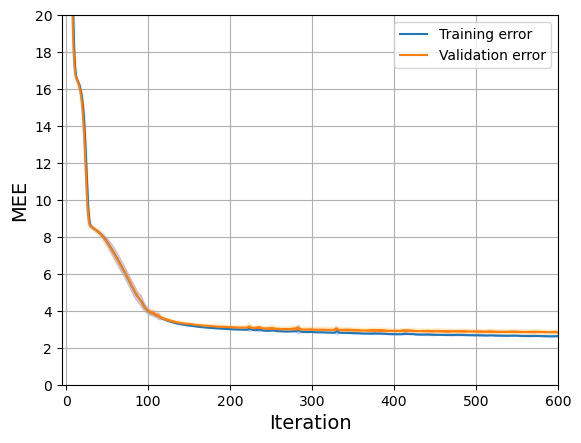

In [20]:
plt.style.use('default')

plt.plot(range(len(historyTr_NoReg_mean)),historyTr_NoReg_mean, label = 'Training error')
plt.fill_between(range(len(historyTr_NoReg_mean)), historyTr_NoReg_mean - historyTr_NoReg_sd, 
                 historyTr_NoReg_mean + historyTr_NoReg_sd, 
                 color='b', alpha=0.15)

plt.plot(range(len(historyVal_NoReg_mean)), historyVal_NoReg_mean, label = 'Validation error')
plt.fill_between(range(len(historyVal_NoReg_mean)), historyVal_NoReg_mean - historyVal_NoReg_sd, 
                 historyVal_NoReg_mean + historyVal_NoReg_sd, 
                 color='orange', alpha=0.15)

plt.ylabel('MEE', fontsize = 14)
plt.xlabel('Iteration', fontsize = 14)
plt.legend()
plt.ylim(5,20)
plt.xlim(-5,600)
plt.yticks(np.arange(0, 21, +2))

plt.grid()

In [21]:
print("No regularization (no alpha) result:")
print("MEE on the validation",historyVal_NoReg_mean[-1],"with standard deviation",historyVal_NoReg_sd[-1])
print("MEE on the training",historyTr_NoReg_mean[-1],"with standard deviation",historyTr_NoReg_sd[-1])

No regularization (no alpha) result:
MEE on the validation 2.8283557891845703 with standard deviation 0.12234814579802553
MEE on the training 2.6282647132873533 with standard deviation 0.039828152082425426


In [22]:
def create_model_Low_LR():
    # create model
    model = Sequential()
    model.add(Dense(mlpr.best_params_['unit1'], input_dim=10, activation=mlpr.best_params_['act'], 
                    kernel_regularizer=l2(mlpr.best_params_['alpha']),
                    kernel_initializer=RandomUniform(minval=-0.7, maxval=0.7, seed=1)))
    model.add(Dense(mlpr.best_params_['unit2'], activation=mlpr.best_params_['act'], 
                    kernel_regularizer=l2(mlpr.best_params_['alpha']),
                    kernel_initializer=RandomUniform(minval=-0.7, maxval=0.7, seed=1)))
    model.add(Dense(2, activation='linear'))
    # Compile model
    model.compile(loss=[MEE_k], optimizer= SGD(lr=0.01, 
                                                            momentum=mlpr.best_params_['mom']))
    return model

In [23]:
historyVal_Low_LR = []
historyTr_Low_LR = []

#mc = ModelCheckpoint('best_modelLC2HL.h5', monitor='val_loss', save_best_only=True)

for traing_index, test_index in kf.split(X_dev):
    x_tr = X_dev[traing_index]
    y_tr = y_dev[traing_index]
    x_val = X_dev[test_index]
    y_val = y_dev[test_index]
    model=create_model_Low_LR()
    #model.add_loss(MEE_k)
    history=model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=600, 
                      batch_size=1036).history
    historyVal_Low_LR.append(history['val_loss'])
    historyTr_Low_LR.append(history['loss'])
model=create_model_Low_LR()
#model.add_loss(MEE_k)
model.fit(X_dev, y_dev, epochs=600, 
                      batch_size=1036).history

Epoch 1/600
1/1 [==============================] - 0s 254ms/step - loss: 56.7120 - val_loss: 56.5695
Epoch 2/600
1/1 [==============================] - 0s 184ms/step - loss: 56.6329 - val_loss: 56.4508
Epoch 3/600
1/1 [==============================] - 0s 90ms/step - loss: 56.5142 - val_loss: 56.3121
Epoch 4/600
1/1 [==============================] - 0s 78ms/step - loss: 56.3754 - val_loss: 56.1631
Epoch 5/600
1/1 [==============================] - 0s 76ms/step - loss: 56.2264 - val_loss: 56.0086
Epoch 6/600
1/1 [==============================] - 0s 73ms/step - loss: 56.0718 - val_loss: 55.8510
Epoch 7/600
1/1 [==============================] - 0s 78ms/step - loss: 55.9141 - val_loss: 55.6914
Epoch 8/600
1/1 [==============================] - 0s 86ms/step - loss: 55.7544 - val_loss: 55.5302
Epoch 9/600
1/1 [==============================] - 0s 80ms/step - loss: 55.5932 - val_loss: 55.3677
Epoch 10/600
1/1 [==============================] - 0s 80ms/step - loss: 55.4307 - val_loss: 55.20

{'loss': [56.056495666503906,
  55.85679244995117,
  55.57767868041992,
  55.27431106567383,
  54.959659576416016,
  54.63650894165039,
  54.30466842651367,
  53.96346664428711,
  53.61177062988281,
  53.248931884765625,
  52.87406921386719,
  52.48649978637695,
  52.08543014526367,
  51.670413970947266,
  51.24101257324219,
  50.79688262939453,
  50.337833404541016,
  49.86350631713867,
  49.37353515625,
  48.868247985839844,
  48.34745407104492,
  47.811710357666016,
  47.261173248291016,
  46.69626235961914,
  46.117698669433594,
  45.52598190307617,
  44.92191696166992,
  44.30610656738281,
  43.67923355102539,
  43.04209518432617,
  42.395904541015625,
  41.74115753173828,
  41.07905578613281,
  40.40959167480469,
  39.73381042480469,
  39.05263900756836,
  38.36717987060547,
  37.678550720214844,
  36.98716354370117,
  36.293113708496094,
  35.59661102294922,
  34.899559020996094,
  34.2044563293457,
  33.51380920410156,
  32.82879638671875,
  32.14908981323242,
  31.475069046020

In [24]:
historyVal_Low_LR_mean=np.mean(historyVal_Low_LR, axis=0)
historyTr_Low_LR_mean=np.mean(historyTr_Low_LR, axis=0)

historyVal_Low_LR_sd=np.std(historyVal_Low_LR, axis=0)
historyTr_Low_LR_sd=np.std(historyTr_Low_LR, axis=0)

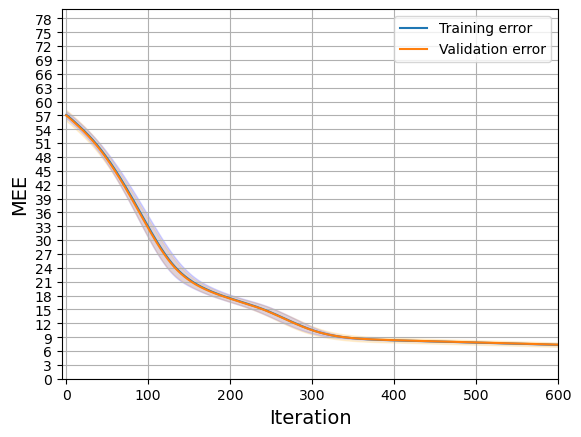

In [25]:
plt.style.use('default')

plt.plot(range(len(historyTr_Low_LR_mean)),historyTr_Low_LR_mean, label = 'Training error')
plt.fill_between(range(len(historyTr_Low_LR_mean)), historyTr_Low_LR_mean - historyTr_Low_LR_sd, 
                 historyTr_Low_LR_mean + historyTr_Low_LR_sd, 
                 color='b', alpha=0.15)

plt.plot(range(len(historyVal_Low_LR_mean)), historyVal_Low_LR_mean, label = 'Validation error')
plt.fill_between(range(len(historyVal_Low_LR_mean)), historyVal_Low_LR_mean - historyVal_Low_LR_sd, 
                 historyVal_Low_LR_mean + historyVal_Low_LR_sd, 
                 color='orange', alpha=0.15)

plt.ylabel('MEE', fontsize = 14)
plt.xlabel('Iteration', fontsize = 14)
plt.legend()
plt.ylim(5,80)
plt.xlim(-5,600)
plt.yticks(np.arange(0, 81, +3))

plt.grid()

In [26]:
print("Low regularization (lr=0.01) result:")
print("MEE on the validation",historyVal_Low_LR_mean[-1],"with standard deviation",historyVal_Low_LR_sd[-1])
print("MEE on the training",historyTr_Low_LR_mean[-1],"with standard deviation",historyTr_Low_LR_sd[-1])

Low regularization (lr=0.01) result:
MEE on the validation 7.383029651641846 with standard deviation 0.4687370612742865
MEE on the training 7.350340843200684 with standard deviation 0.07202775080340545


In [27]:
def create_model_MB():
    # create model
    model = Sequential()
    model.add(Dense(mlpr.best_params_['unit1'], input_dim=10, activation=mlpr.best_params_['act'], 
                    kernel_regularizer=l2(mlpr.best_params_['alpha']),
                    kernel_initializer=RandomUniform(minval=-0.7, maxval=0.7, seed=1)))
    model.add(Dense(mlpr.best_params_['unit2'], activation=mlpr.best_params_['act'], 
                    kernel_regularizer=l2(mlpr.best_params_['alpha']),
                    kernel_initializer=RandomUniform(minval=-0.7, maxval=0.7, seed=1)))
    model.add(Dense(2, activation='linear'))
    # Compile model
    model.compile(loss=[MEE_k], optimizer= SGD(lr=0.1, 
                                                            momentum=mlpr.best_params_['mom']))
    return model

In [28]:
historyVal_MB = []
historyTr_MB = []

#mc = ModelCheckpoint('best_modelLC2HL.h5', monitor='val_loss', save_best_only=True)

for traing_index, test_index in kf.split(X_dev):
    x_tr = X_dev[traing_index]
    y_tr = y_dev[traing_index]
    x_val = X_dev[test_index]
    y_val = y_dev[test_index]
    model=create_model_MB()
    #model.add_loss(MEE_k)
    history=model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=600, 
                      batch_size=100).history
    historyVal_MB.append(history['val_loss'])
    historyTr_MB.append(history['loss'])
model=create_model_MB()
#model.add_loss(MEE_k)
model.fit(X_dev, y_dev, epochs=600, 
                      batch_size=100).history

Epoch 1/600
11/11 [==============================] - 0s 40ms/step - loss: 47.3277 - val_loss: 30.2117
Epoch 2/600
11/11 [==============================] - 0s 9ms/step - loss: 22.3621 - val_loss: 16.7536
Epoch 3/600
11/11 [==============================] - 0s 8ms/step - loss: 14.5474 - val_loss: 10.6436
Epoch 4/600
11/11 [==============================] - 0s 9ms/step - loss: 8.8987 - val_loss: 8.1628
Epoch 5/600
11/11 [==============================] - 0s 12ms/step - loss: 7.8537 - val_loss: 7.6813
Epoch 6/600
11/11 [==============================] - 0s 13ms/step - loss: 7.2426 - val_loss: 7.0509
Epoch 7/600
11/11 [==============================] - 0s 12ms/step - loss: 6.6129 - val_loss: 6.4110
Epoch 8/600
11/11 [==============================] - 0s 12ms/step - loss: 5.9470 - val_loss: 5.7800
Epoch 9/600
11/11 [==============================] - 0s 12ms/step - loss: 5.1586 - val_loss: 5.0538
Epoch 10/600
11/11 [==============================] - 0s 11ms/step - loss: 4.5657 - val_loss: 4.6

{'loss': [46.71730422973633,
  20.152318954467773,
  11.95750904083252,
  8.428056716918945,
  7.929474830627441,
  7.340498924255371,
  6.662458419799805,
  5.9311981201171875,
  5.1826958656311035,
  4.5927205085754395,
  4.170983791351318,
  3.9073517322540283,
  3.7247838973999023,
  3.568211078643799,
  3.410874843597412,
  3.2862448692321777,
  3.2440707683563232,
  3.1881356239318848,
  3.1353983879089355,
  3.0726704597473145,
  3.0817902088165283,
  3.0227091312408447,
  2.967646598815918,
  2.977918863296509,
  2.9356770515441895,
  2.9272232055664062,
  2.9249727725982666,
  2.920020818710327,
  2.858696222305298,
  2.875558853149414,
  2.8549695014953613,
  2.8530218601226807,
  2.842785358428955,
  2.8152689933776855,
  2.805387020111084,
  2.822376251220703,
  2.803217649459839,
  2.7948267459869385,
  2.770052671432495,
  2.7735109329223633,
  2.773333787918091,
  2.778918743133545,
  2.7444944381713867,
  2.755143404006958,
  2.754246711730957,
  2.731682777404785,
  2.

In [29]:
historyVal_MB_mean=np.mean(historyVal_MB, axis=0)
historyTr_MB_mean=np.mean(historyTr_MB, axis=0)

historyVal_MB_sd=np.std(historyVal_MB, axis=0)
historyTr_MB_sd=np.std(historyTr_MB, axis=0)

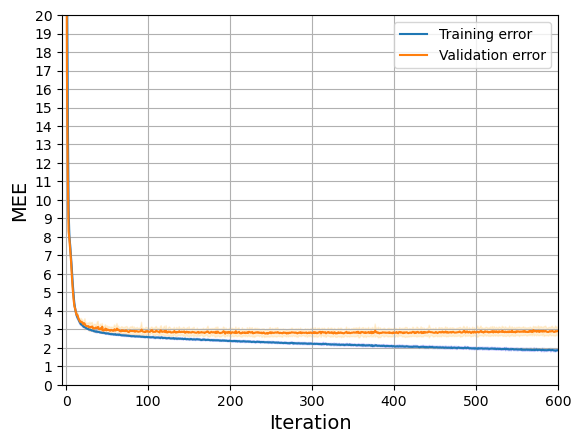

In [30]:
plt.style.use('default')

plt.plot(range(len(historyTr_MB_mean)),historyTr_MB_mean, label = 'Training error')
plt.fill_between(range(len(historyTr_MB_mean)), historyTr_MB_mean - historyTr_MB_sd, 
                 historyTr_MB_mean + historyTr_MB_sd, 
                 color='b', alpha=0.15)

plt.plot(range(len(historyVal_MB_mean)), historyVal_MB_mean, label = 'Validation error')
plt.fill_between(range(len(historyVal_MB_mean)), historyVal_MB_mean - historyVal_MB_sd, 
                 historyVal_MB_mean + historyVal_MB_sd, 
                 color='orange', alpha=0.15)

plt.ylabel('MEE', fontsize = 14)
plt.xlabel('Iteration', fontsize = 14)
plt.legend()
plt.ylim(5,20)
plt.xlim(-5,600)
plt.yticks(np.arange(0, 21, +1))

plt.grid()

In [31]:
print("Mini batch (mb=100) result:")
print("MEE on the validation",historyVal_MB_mean[-1],"with standard deviation",historyVal_MB_sd[-1])
print("MEE on the training",historyTr_MB_mean[-1],"with standard deviation",historyTr_MB_sd[-1])

Mini batch (mb=100) result:
MEE on the validation 2.895853042602539 with standard deviation 0.232702346020446
MEE on the training 1.8649487495422363 with standard deviation 0.06880880003739917


In [32]:
def create_model_OL():
    # create model
    model = Sequential()
    model.add(Dense(mlpr.best_params_['unit1'], input_dim=10, activation=mlpr.best_params_['act'], 
                    kernel_regularizer=l2(mlpr.best_params_['alpha']),
                    kernel_initializer=RandomUniform(minval=-0.7, maxval=0.7, seed=1)))
    model.add(Dense(mlpr.best_params_['unit2'], activation=mlpr.best_params_['act'], 
                    kernel_regularizer=l2(mlpr.best_params_['alpha']),
                    kernel_initializer=RandomUniform(minval=-0.7, maxval=0.7, seed=1)))
    model.add(Dense(2, activation='linear'))
    # Compile model
    model.compile(loss=[MEE_k], optimizer= SGD(lr=0.01, 
                                                            momentum=mlpr.best_params_['mom']))
    return model

In [33]:
historyVal_OL = []
historyTr_OL = []

#mc = ModelCheckpoint('best_modelLC2HL.h5', monitor='val_loss', save_best_only=True)

for traing_index, test_index in kf.split(X_dev):
    x_tr = X_dev[traing_index]
    y_tr = y_dev[traing_index]
    x_val = X_dev[test_index]
    y_val = y_dev[test_index]
    model=create_model_OL()
    #model.add_loss(MEE_k)
    history=model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=100, batch_size=1).history
    historyVal_OL.append(history['val_loss'])
    historyTr_OL.append(history['loss'])
#model=create_model_OL()
#model.add_loss(MEE_k)
#model.fit(X_dev, y_dev, epochs=100, 
                    #  batch_size=1).history

Epoch 1/100
1036/1036 [==============================] - 3s 3ms/step - loss: 12.6401 - val_loss: 5.0677
Epoch 2/100
1036/1036 [==============================] - 3s 3ms/step - loss: 4.2901 - val_loss: 3.8571
Epoch 3/100
1036/1036 [==============================] - 3s 3ms/step - loss: 3.5978 - val_loss: 3.6670
Epoch 4/100
1036/1036 [==============================] - 3s 3ms/step - loss: 3.4240 - val_loss: 3.4831
Epoch 5/100
1036/1036 [==============================] - 3s 3ms/step - loss: 3.2769 - val_loss: 3.1473
Epoch 6/100
1036/1036 [==============================] - 3s 3ms/step - loss: 3.1960 - val_loss: 3.5719
Epoch 7/100
1036/1036 [==============================] - 3s 3ms/step - loss: 3.1642 - val_loss: 3.5089
Epoch 8/100
1036/1036 [==============================] - 3s 3ms/step - loss: 3.0667 - val_loss: 3.1592
Epoch 9/100
1036/1036 [==============================] - 2s 2ms/step - loss: 3.0005 - val_loss: 3.3057
Epoch 10/100
1036/1036 [==============================] - 3s 3ms/step - 

In [34]:
historyVal_OL_mean=np.mean(historyVal_OL, axis=0)
historyTr_OL_mean=np.mean(historyTr_OL, axis=0)

historyVal_OL_sd=np.std(historyVal_OL, axis=0)
historyTr_OL_sd=np.std(historyTr_OL, axis=0)

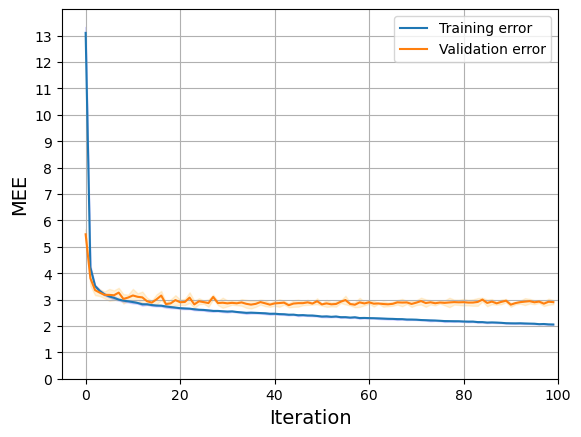

In [35]:
plt.style.use('default')

plt.plot(range(len(historyTr_OL_mean)),historyTr_OL_mean, label = 'Training error')
plt.fill_between(range(len(historyTr_OL_mean)), historyTr_OL_mean - historyTr_OL_sd, 
                 historyTr_OL_mean + historyTr_OL_sd, 
                 color='b', alpha=0.15)

plt.plot(range(len(historyVal_OL_mean)), historyVal_OL_mean, label = 'Validation error')
plt.fill_between(range(len(historyVal_OL_mean)), historyVal_OL_mean - historyVal_OL_sd, 
                 historyVal_OL_mean + historyVal_OL_sd, 
                 color='orange', alpha=0.15)

plt.ylabel('MEE', fontsize = 14)
plt.xlabel('Iteration', fontsize = 14)

plt.legend()
plt.ylim(5,14)
plt.xlim(-5,100)
plt.yticks(np.arange(0, 14, +1))

plt.grid()

In [36]:
print("OnLine batch result:")
print("MEE on the validation",historyVal_OL_mean[-1],"with standard deviation",historyVal_OL_sd[-1])
print("MEE on the training",historyTr_OL_mean[-1],"with standard deviation",historyTr_OL_sd[-1])

OnLine batch result:
MEE on the validation 2.900324821472168 with standard deviation 0.08101321863665002
MEE on the training 2.0539805412292482 with standard deviation 0.02080189661650085


In [37]:
def create_model_LM():
    # create model
    model = Sequential()
    model.add(Dense(mlpr.best_params_['unit1'], input_dim=10, activation=mlpr.best_params_['act'], 
                    kernel_regularizer=l2(mlpr.best_params_['alpha']),
                    kernel_initializer=RandomUniform(minval=-0.7, maxval=0.7, seed=1)))
    model.add(Dense(mlpr.best_params_['unit2'], activation=mlpr.best_params_['act'], 
                    kernel_regularizer=l2(mlpr.best_params_['alpha']),
                    kernel_initializer=RandomUniform(minval=-0.7, maxval=0.7, seed=1)))
    model.add(Dense(2, activation='linear'))
    # Compile model
    model.compile(loss=[MEE_k], optimizer= SGD(lr=mlpr.best_params_['lr'], 
                                                            momentum=0.01))
    return model

In [38]:
historyVal_LM = []
historyTr_LM = []

#mc = ModelCheckpoint('best_modelLC2HL.h5', monitor='val_loss', save_best_only=True)

for traing_index, test_index in kf.split(X_dev):
    x_tr = X_dev[traing_index]
    y_tr = y_dev[traing_index]
    x_val = X_dev[test_index]
    y_val = y_dev[test_index]
    model=create_model_LM()
    history=model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=600, batch_size=1036).history
    historyVal_LM.append(history['val_loss'])
    historyTr_LM.append(history['loss'])


Epoch 1/600
1/1 [==============================] - 0s 232ms/step - loss: 55.8411 - val_loss: 53.7189
Epoch 2/600
1/1 [==============================] - 0s 62ms/step - loss: 54.2666 - val_loss: 52.0212
Epoch 3/600
1/1 [==============================] - 0s 49ms/step - loss: 52.5744 - val_loss: 50.1200
Epoch 4/600
1/1 [==============================] - 0s 55ms/step - loss: 50.6766 - val_loss: 47.9417
Epoch 5/600
1/1 [==============================] - 0s 52ms/step - loss: 48.5002 - val_loss: 45.4395
Epoch 6/600
1/1 [==============================] - 0s 57ms/step - loss: 46.0005 - val_loss: 42.6063
Epoch 7/600
1/1 [==============================] - 0s 71ms/step - loss: 43.1723 - val_loss: 39.4774
Epoch 8/600
1/1 [==============================] - 0s 73ms/step - loss: 40.0522 - val_loss: 36.1198
Epoch 9/600
1/1 [==============================] - 0s 64ms/step - loss: 36.7101 - val_loss: 32.6472
Epoch 10/600
1/1 [==============================] - 0s 90ms/step - loss: 33.2656 - val_loss: 29.241

In [39]:
historyVal_LM_mean=np.mean(historyVal_LM, axis=0)
historyTr_LM_mean=np.mean(historyTr_LM, axis=0)

historyVal_LM_sd=np.std(historyVal_LM, axis=0)
historyTr_LM_sd=np.std(historyTr_LM, axis=0)

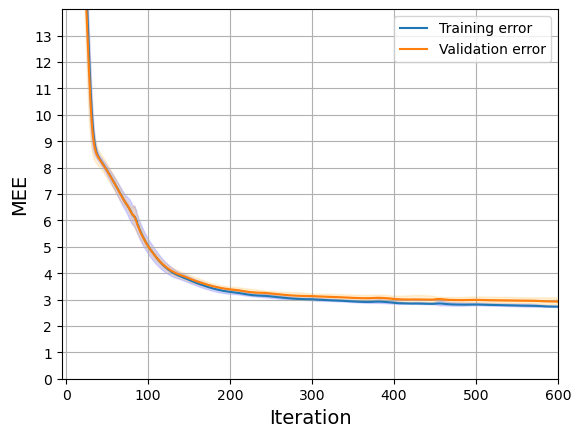

In [40]:
plt.style.use('default')

plt.plot(range(len(historyTr_LM_mean)),historyTr_LM_mean, label = 'Training error')
plt.fill_between(range(len(historyTr_LM_mean)), historyTr_LM_mean - historyTr_LM_sd, 
                 historyTr_LM_mean + historyTr_LM_sd, 
                 color='b', alpha=0.15)

plt.plot(range(len(historyVal_LM_mean)), historyVal_LM_mean, label = 'Validation error')
plt.fill_between(range(len(historyVal_LM_mean)), historyVal_LM_mean - historyVal_LM_sd, 
                 historyVal_LM_mean + historyVal_LM_sd, 
                 color='orange', alpha=0.15)

plt.ylabel('MEE', fontsize = 14)
plt.xlabel('Iteration', fontsize = 14)
plt.legend()
plt.ylim(5,14)
plt.xlim(-5,600)
plt.yticks(np.arange(0, 14, +1))

plt.grid()

In [41]:
print("Low momentum (mom=0.01) result:")
print("MEE on the validation",historyVal_LM_mean[-1],"with standard deviation",historyVal_LM_sd[-1])
print("MEE on the training",historyTr_LM_mean[-1],"with standard deviation",historyTr_LM_sd[-1])

Low momentum (mom=0.01) result:
MEE on the validation 2.92079701423645 with standard deviation 0.13706766883313531
MEE on the training 2.7291064262390137 with standard deviation 0.0289291966534779


In [42]:
def create_model_ES():
    # create model
    model = Sequential()
    model.add(Dense(50, input_dim=10, activation=mlpr.best_params_['act'], 
                    kernel_regularizer=l2(mlpr.best_params_['alpha']),
                    kernel_initializer=RandomUniform(minval=-0.7, maxval=0.7, seed=1)))
    model.add(Dense(25, activation=mlpr.best_params_['act'], 
                    kernel_regularizer=l2(mlpr.best_params_['alpha']),
                    kernel_initializer=RandomUniform(minval=-0.7, maxval=0.7, seed=1)))
    model.add(Dense(2, activation='linear'))
    # Compile model
    model.compile(loss=[MEE_k], optimizer= SGD(lr=mlpr.best_params_['lr'], 
                                                            momentum=mlpr.best_params_['mom']))
    return model

In [43]:
historyVal_ES = []
historyTr_ES = []

el=EarlyStopping(monitor='val_loss', patience=50)


for traing_index, test_index in kf.split(X_dev):
    x_tr = X_dev[traing_index]
    y_tr = y_dev[traing_index]
    x_val = X_dev[test_index]
    y_val = y_dev[test_index]
    model=create_model_ES()
    #model.add_loss(MEE_k)
    history=model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=600, 
                      batch_size=1036, callbacks=[el]).history
    historyVal_ES.append(history['val_loss'])
    historyTr_ES.append(history['loss'])


Epoch 1/600
1/1 [==============================] - 0s 325ms/step - loss: 56.5841 - val_loss: 55.0912
Epoch 2/600
1/1 [==============================] - 0s 79ms/step - loss: 55.1750 - val_loss: 52.8561
Epoch 3/600
1/1 [==============================] - 0s 113ms/step - loss: 52.9416 - val_loss: 49.9200
Epoch 4/600
1/1 [==============================] - 0s 106ms/step - loss: 50.0089 - val_loss: 46.2256
Epoch 5/600
1/1 [==============================] - 0s 82ms/step - loss: 46.3187 - val_loss: 41.7820
Epoch 6/600
1/1 [==============================] - 0s 90ms/step - loss: 41.8788 - val_loss: 36.7501
Epoch 7/600
1/1 [==============================] - 0s 113ms/step - loss: 36.8519 - val_loss: 31.3842
Epoch 8/600
1/1 [==============================] - 0s 84ms/step - loss: 31.5063 - val_loss: 26.1761
Epoch 9/600
1/1 [==============================] - 0s 83ms/step - loss: 26.3767 - val_loss: 22.1741
Epoch 10/600
1/1 [==============================] - 0s 99ms/step - loss: 22.4745 - val_loss: 19.

In [44]:
min_k=600
for i in range(0,5):
    if len(historyVal_ES[i])<min_k:
        min_k=len(historyVal_ES[i])
for i in range(0,5):
    del historyVal_ES[i][min_k:]
    del historyTr_ES[i][min_k:]

In [45]:
mc_ES = ModelCheckpoint('Early_stopping_BEST.h5', monitor='val_loss', save_best_only=True)

model=create_model_ES()
#model.add_loss(MEE_k)
model.fit(X_dev, y_dev, epochs=min_k, 
                      batch_size=1036, callbacks=[mc_ES]).history

Epoch 1/474
2/2 [==============================] - 0s 5ms/step - loss: 55.9473
Epoch 2/474
2/2 [==============================] - 0s 3ms/step - loss: 52.0790
Epoch 3/474
2/2 [==============================] - 0s 3ms/step - loss: 45.5769
Epoch 4/474
2/2 [==============================] - 0s 3ms/step - loss: 35.9214
Epoch 5/474
2/2 [==============================] - 0s 3ms/step - loss: 24.9257
Epoch 6/474
2/2 [==============================] - 0s 3ms/step - loss: 18.9949
Epoch 7/474
2/2 [==============================] - 0s 4ms/step - loss: 16.5741
Epoch 8/474
2/2 [==============================] - 0s 4ms/step - loss: 15.1720
Epoch 9/474
2/2 [==============================] - 0s 4ms/step - loss: 13.5834
Epoch 10/474
2/2 [==============================] - 0s 4ms/step - loss: 11.6090
Epoch 11/474
2/2 [==============================] - 0s 4ms/step - loss: 9.7904
Epoch 12/474
2/2 [==============================] - 0s 3ms/step - loss: 8.8330
Epoch 13/474
2/2 [==============================] -

{'loss': [55.94728469848633,
  52.07895278930664,
  45.57687759399414,
  35.92137908935547,
  24.925676345825195,
  18.994943618774414,
  16.574140548706055,
  15.171977996826172,
  13.583379745483398,
  11.609012603759766,
  9.79041862487793,
  8.833045959472656,
  8.511301040649414,
  8.306008338928223,
  8.100603103637695,
  7.909032821655273,
  7.723032474517822,
  7.538015842437744,
  7.3430352210998535,
  7.161631107330322,
  6.972282409667969,
  6.829354763031006,
  6.633838653564453,
  6.441385269165039,
  6.269529342651367,
  6.100556373596191,
  5.893163681030273,
  5.716915607452393,
  5.468841075897217,
  5.293971538543701,
  5.050141334533691,
  4.861372470855713,
  4.671133041381836,
  4.460111618041992,
  4.2985405921936035,
  4.171308517456055,
  4.176867961883545,
  3.9387428760528564,
  3.8818676471710205,
  3.836468458175659,
  3.7436470985412598,
  3.6841416358947754,
  3.651240587234497,
  3.709040880203247,
  3.535449981689453,
  3.4952337741851807,
  3.4794740676

In [46]:
historyVal_ES_mean=np.mean(historyVal_ES, axis=0)
historyTr_ES_mean=np.mean(historyTr_ES, axis=0)

historyVal_ES_sd=np.std(historyVal_ES, axis=0)
historyTr_ES_sd=np.std(historyTr_ES, axis=0)

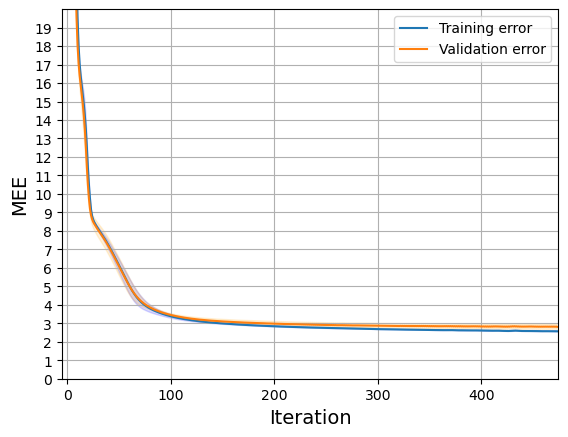

In [47]:
plt.style.use('default')

plt.plot(range(len(historyTr_ES_mean)),historyTr_ES_mean, label = 'Training error')
plt.fill_between(range(len(historyTr_ES_mean)), historyTr_ES_mean - historyTr_ES_sd, 
                 historyTr_ES_mean + historyTr_ES_sd, 
                 color='b', alpha=0.15)

plt.plot(range(len(historyVal_ES_mean)), historyVal_ES_mean, label = 'Validation error')
plt.fill_between(range(len(historyVal_ES_mean)), historyVal_ES_mean - historyVal_ES_sd, 
                 historyVal_ES_mean + historyVal_ES_sd, 
                 color='orange', alpha=0.15)

plt.ylabel('MEE', fontsize = 14)
plt.xlabel('Iteration', fontsize = 14)
plt.legend()
plt.ylim(5,20)
plt.xlim(-5,min_k)
plt.yticks(np.arange(0, 20, +1))

plt.grid()

In [48]:
print("Best model with Early Stopping result:")
print("MEE on the validation",historyVal_ES_mean[-1],"with standard deviation",historyVal_ES_sd[-1])
print("MEE on the training",historyTr_ES_mean[-1],"with standard deviation",historyTr_ES_sd[-1])

Best model with Early Stopping result:
MEE on the validation 2.8103395462036134 with standard deviation 0.1416157867408675
MEE on the training 2.565181541442871 with standard deviation 0.03064434635943835


In [49]:
print(min_k)

474
